In [9]:
import cupy as np
import matplotlib.pyplot as plt
import os
import time
from sklearn.utils.extmath import randomized_svd
from layers2 import MatMul, softmax
from model import SimpleCbow


def print_result(current, total, begin, end):
    lis = ['[' if i == 0 else ']' if i == 21 else ' ' for i in range(22)]
    index = int(current/total*20)
    percentage = format(current*100 / total, '.2f')
    if 0 <= index < 20:
        pass
    else:
        index = 20
    if index > 0:
        for i in range(1,index+1):
            lis[i] = u'\\u25A0'
        string = ''.join(lis)
        time = end-  begin
        print(f'\\r{string} {percentage}% Time: {time:.3f}s', end='', flush=True)
    else:
        string = ''.join(lis)
        time = end-  begin
        print(f'\\r{string} {percentage}% Time: {time:.3f}s', end='', flush=True)

| epoch 100   |  iter 261   / 274   | time         79[s] | loss 4.76

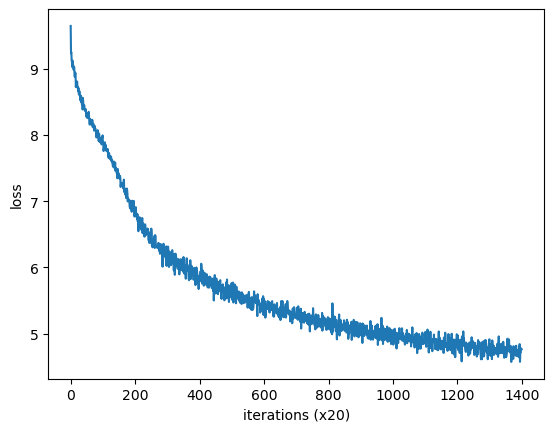

In [14]:
def remove_duplicate(params, grads):
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                if params[i] is params[j]:
                    grads[i] += grads[j] 
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                elif params[i].ndim == 2 and params[j].ndim == 2 and params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self,
            x,
            t,
            max_epoch=10,
            batch_size=32,
            max_grad=None,
            eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]
            for iters in range(max_iters):
                batch_x = x[iters * batch_size:(iters + 1) * batch_size]
                batch_t = t[iters * batch_size:(iters + 1) * batch_size]

                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params,
                                                 model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評価
                if (eval_interval
                        is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print(
                        '\r| epoch %-5d |  iter %-5d / %-5d | time %10d[s] | loss %.2f'
                        % (self.current_epoch + 1, iters + 1, max_iters,
                           elapsed_time, avg_loss),
                        end='',
                        flush=True)
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x.get(), self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()


class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (
            1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])

            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

class Preprocess:
    def __init__(self, text: str, *args):
        dictionary = {i: f' {i}' for i in args}
        text = text.lower()
        for i in dictionary:
            text = text.replace(i, dictionary.get(i))
        self.text = text.split(' ')
        self.repeated = []
        
    def get_word_id(self):
        dictionary = {}
        dictionary2 = {}
        corpus = []
        append = corpus.append
        counter = 0
        for index, i in enumerate(self.text):
            if i not in dictionary:
                dictionary[i] = counter
                dictionary2[counter] = i
                counter += 1
                append(dictionary[i])
            else:
                append(dictionary[i])
                self.repeated.append(index)
        return dictionary, dictionary2, corpus

    def get_single_context(self,id_word:dict, word_id:dict, corpus: list, word: str,window: int):  # list bound check
        text = self.text
        word = word.lower()
        length = len(text)
        if word not in text:
            return
        ls = [0] * len(corpus)
        for index, i in enumerate(text):
            if word_id[i] == word_id[word]:    
                if index == 0:
                    counter = 1
                    for k in range(window):
                        ls[counter] += 1
                        counter += 1
                elif index == length - 1:
                    counter = 1
                    for p in range(window):
                        ls[-1-counter] += 1
                        counter += 1
                else:
                    counter = counter2 = 1
                    word1_id = word_id[text[index - counter]]
                    word2_id = word_id[text[index + counter2]]
                    for p in range(window):
                        ls[word1_id] += 1
                        ls[word2_id] += 1
                        counter += 1
                        counter2 += 1
                        
        return np.array(ls, dtype = 'uint8')

    def get_coocurrenceMatrix(self,corpus: list,id_word: dict, word_id: dict, window:int):
        ls = []
        append = ls.append
        total = len(word_id)
        begin = time()
        for index, i in enumerate(word_id):
            append(self.get_single_context(id_word, word_id, corpus, i, window))
            print_result(index+1, total, begin, time())
        return np.array(ls, dtype = 'uint8'), ls
    
    def create_context_target(self, corpus, windowsize = 1):
        target = corpus[1 : -1]
        context = []
        cs = []
        cs_append = cs.append
        context_append = context.append
        for i in range(windowsize, len(corpus)-1):
            cs.append(corpus[i-1])
            cs.append(corpus[i+1])
            context.append(cs)
            cs=[]
        return np.array(context), np.array(target)
    
    def convert_onehot(self, context, target, length):
        zero_context = np.zeros(shape=(*context.shape, length), dtype = 'uint8')
        zero_target = np.zeros(shape=(*target.shape, length), dtype = 'uint8')
        for index, i in enumerate(context):
            for index2, k in enumerate(i):
                zero_context[index, index2, k] = 1
        for index, i in enumerate(target):
                zero_target[index, i] = 1
        return zero_context, zero_target
    
    def PPMI(self, co_matrix, corpus, verbose=True):
        ppmi_matrix = np.zeros_like(co_matrix, dtype=np.float32)
        N = np.sum(co_matrix)
        sigle_word = np.sum(co_matrix, axis = 0)
        total = co_matrix.shape[0]*co_matrix.shape[1]
        cols = co_matrix.shape[1]
        cnt = 0
        begin = time()
        for i in range(co_matrix.shape[0]):
            for j in range(co_matrix.shape[1]):
                ppmi = np.log2(co_matrix[i,j]*N/(sigle_word[i]*sigle_word[j]) + 1e-8)
                ppmi_matrix[i,j] = max(0, ppmi)
                if verbose:
                    cnt += 1
                    if cnt % (total//200) == 0:
                        print_result(cnt+1,total, begin, time())
        return ppmi_matrix
    def most_similar(self, matrix:list, word:str,word_id:dict, top:int):
        word = word.lower()
        if word not in word_id:
            return
        word_use_vector = matrix[word_id[word]]
        ls = {id_word[index]:similarity(word_use_vector, i) for index, i in enumerate(matrix) if index is not word_id[word]}
        return sorted(ls.items(),key=lambda x:x[1],reverse=True)[:top]

    def similarity(self, vect1, vect2):
        x = vect1/(np.sqrt(np.sum(vect1**2)) + 1e-8)
        y = vect2/(np.sqrt(np.sum(vect2**2)) + 1e-8)
        return np.dot(x,y)

with open('untitled.txt', mode="r") as fp:
         string = fp.read()
preprocessed = Preprocess(string, ',', '.')
word_id, id_word, corpus = preprocessed.get_word_id()
context, target = preprocessed.create_context_target(corpus)
context_onehot, target_onehot = preprocessed.convert_onehot(context, target, len(word_id))
model = SimpleCbow(len(word_id), 5)
optimizer = Adam()
model.forward(context_onehot, target_onehot)
trainer = Trainer(model, optimizer)
trainer.fit(context_onehot, target_onehot, 100, 50)
trainer.plot()

# cooccurrence_matrix = np.unpackbits(np.load('cooccurrence_matrix3.npy'), axis = 1)

#     def PPMI(co_matrix, corpus, verbose=True):
#     ppmi_matrix = np.zeros_like(co_matrix, dtype=np.float32)
#     N = np.sum(co_matrix)
#     sigle_word = np.sum(co_matrix, axis = 0)
#     total = co_matrix.shape[0]*co_matrix.shape[1]
#     cols = co_matrix.shape[1]
#     cnt = 0
#     begin = time()
#     for i in range(co_matrix.shape[0]):
#         for j in range(co_matrix.shape[1]):
#             ppmi = np.log2(co_matrix[i,j]*N/(sigle_word[i]*sigle_word[j]) + 1e-8)
#             ppmi_matrix[i,j] = max(0, ppmi)
#             if verbose:
#                 cnt += 1
#                 if cnt % (total//200) == 0:
#                     print_result(cnt+1,total, begin, time())
#     return ppmi_matrix
# ppmi = np.load('ppmi.npy')"